In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings
warnings.simplefilter('ignore')

/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# All-Weather Quad Momentum (AWQM) Strategy

The All-Weather Quad Momentum (AWQM) strategy, developed by Todd Tresidder of FinancialMentor.com, incorporates both short-term and long-term momentum to create a diversified portfolio. This strategy is designed to succeed in various economic conditions by tactically allocating to the best-suited assets.

### Strategy Rules

1. **Asset Universe**
   The strategy utilizes a broad set of asset classes that are meant to perform well in different economic conditions:
   - Prosperity: Equities and risk assets
   - Recession: Cash and short-term treasuries
   - Inflation: Gold and TIPS
   - Deflation: Long-term treasuries

2. **Calculation of Momentum**
   The portfolio is split evenly between a long-term and a short-term momentum component.
   - **Short-term momentum** is calculated over the last 1-6 months.
   - **Long-term momentum** is calculated over the last 10-12 months.

   For each asset, calculate the average momentum score:
   $
   \text{Momentum Score} = \frac{r_{1} + r_{3} + r_{6} + r_{12}}{4}
   $
   where $ r_{1} $, $ r_{3} $, $ r_{6} $, and $ r_{12} $ are the returns over the last 1, 3, 6, and 12 months respectively.

3. **Selection of Assets**
   - Rank the assets based on their momentum scores.
   - Select the top 3 or 6 assets with the highest momentum scores.

4. **Absolute Momentum Filter**
   - If an asset's price is below its 10-month moving average, allocate that portion of the portfolio to cash.
   - The allocation to cash serves as a risk management measure to avoid significant drawdowns during periods of market stress.

5. **Portfolio Allocation**
   - **Agg 6 Version**: Hold the top 6 assets, allocating 1/6 of the portfolio to each.
   - **Agg 3 Version**: Hold the top 3 assets, allocating 1/3 of the portfolio to each.

6. **Rebalancing**
   - Rebalance the portfolio monthly on the last trading day of the month.
   - Rebalance the entire portfolio regardless of whether there is a change in the selected assets.

### Commentary

The AWQM strategy employs both relative and absolute momentum to tactically switch between asset classes based on current economic conditions. By combining short-term and long-term momentum, the strategy aims to capture sustained trends while adapting to market changes.

- **Relative Momentum**: Ranks assets based on their performance relative to other assets.
- **Absolute Momentum**: Ensures that selected assets are in an uptrend by comparing their price to the 10-month moving average.

The strategy's use of a diverse set of asset classes helps it to perform well in various economic conditions. However, the strategy can take concentrated positions, leading to higher returns during favorable conditions but also increased risk during adverse market conditions.

### Calculation Notes

- The strategy uses a broad set of asset classes, similar to the Permanent and All-Weather portfolios, but tactically allocates to the best-performing assets.
- The momentum scores are calculated using a blend of short-term and long-term returns to balance the portfolio between sustained trends and recent performance.
- The absolute momentum filter allocates to cash if the selected assets are in a downtrend, reducing exposure to market drawdowns.

### Conclusion

The AWQM strategy is a robust approach to tactical asset allocation that balances short-term and long-term momentum to create a diversified portfolio. By tactically switching between asset classes, the strategy aims to perform well in various economic conditions while managing risk through the use of absolute momentum.


[*********************100%%**********************]  11 of 11 completed


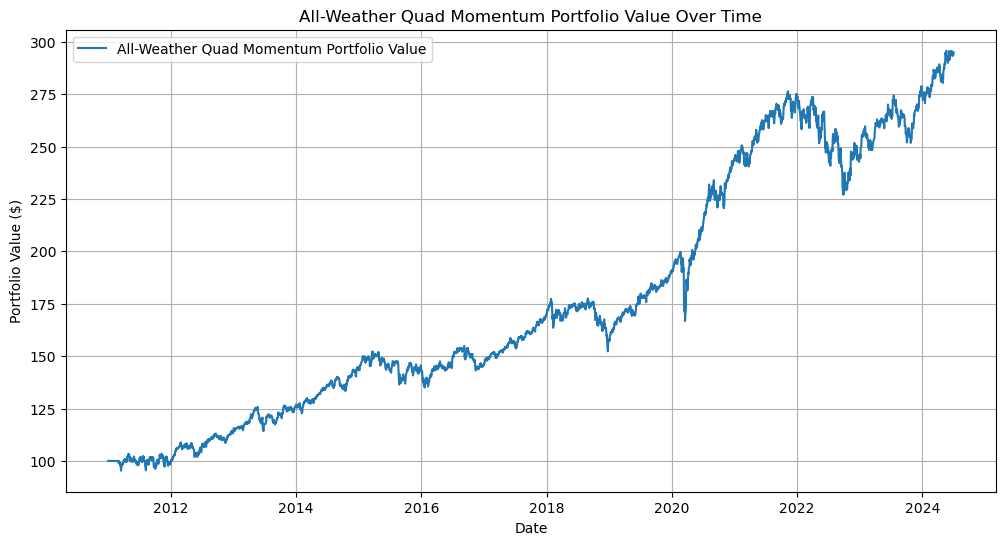

In [3]:
# Define the asset universe
tickers = {
    'domestic_equities': ['SPY', 'QQQ'],
    'international_equities': ['EFA', 'VEU', ],
    'bonds': ['TLT', 'IEF'],
    'commodities_real_estate': ['VNQ', 'RWX', 'DBC', 'GLD'],
    'cash': ['BIL']
}

# Download historical data
start_date = '2010-01-01'
data = yf.download(sum(tickers.values(), []), start=start_date)['Adj Close']

# Calculate monthly returns
monthly_data = data.resample('M').last()
monthly_returns = monthly_data.pct_change().dropna()

# Define lookback periods for long-term and short-term momentum
long_term_lookback = 12  # 10-12 months
short_term_lookback = 6  # 1-6 months

# Function to calculate momentum
def calculate_momentum(data, lookback_period):
    return data.pct_change(periods=lookback_period).dropna()

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=monthly_returns.index, columns=data.columns).fillna(0)

# Perform the strategy
for date in monthly_returns.index[max(long_term_lookback, short_term_lookback):]:
    for quadrant, assets in tickers.items():
        if quadrant == 'cash':
            continue
        # Calculate long-term and short-term momentum
        long_term_momentum = calculate_momentum(monthly_data.loc[:date, assets], long_term_lookback).iloc[-1]
        short_term_momentum = calculate_momentum(monthly_data.loc[:date, assets], short_term_lookback).iloc[-1]
        
        # Select top asset based on long-term momentum
        top_long_term_asset = long_term_momentum.idxmax()
        # Select top asset based on short-term momentum
        top_short_term_asset = short_term_momentum.idxmax()
        
        # Allocate 25% of the portfolio to each quadrant
        # Allocate 50% within each quadrant to top long-term asset and 50% to top short-term asset
        allocations.loc[date, top_long_term_asset] += 0.25 * 0.5
        allocations.loc[date, top_short_term_asset] += 0.25 * 0.5

# Forward fill the allocations to apply the same allocation until the next rebalance
daily_allocations = allocations.resample('D').ffill().reindex(data.index, method='ffill').fillna(0)

# Calculate daily returns
daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

# Calculate portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='All-Weather Quad Momentum Portfolio Value')
plt.title('All-Weather Quad Momentum Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


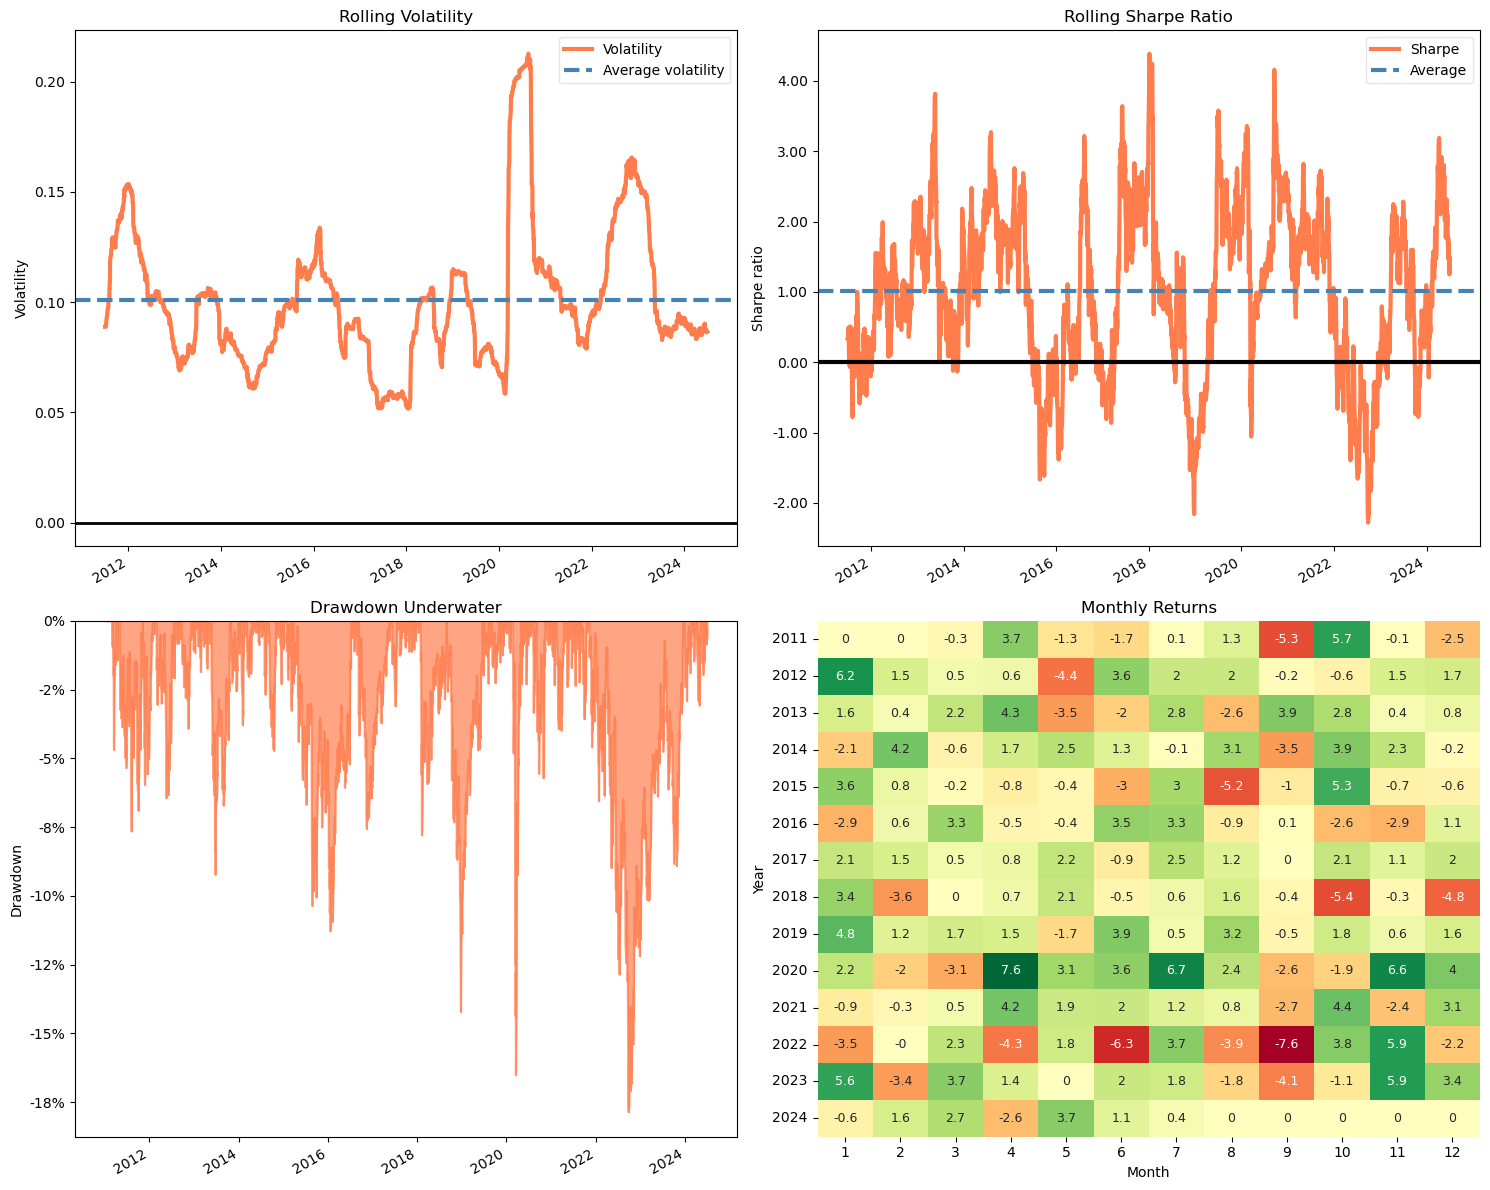

Annual return          0.083577
Cumulative returns     1.949694
Annual volatility      0.104673
Sharpe ratio           0.819376
Calmar ratio           0.467855
Stability              0.963042
Max drawdown          -0.178639
Omega ratio            1.155135
Sortino ratio          1.147883
Skew                  -0.446696
Kurtosis               5.579761
Tail ratio             0.943923
Daily value at risk   -0.012847
dtype: float64


In [5]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

[*********************100%%**********************]  11 of 11 completed
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:5

/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be re

/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_momentum = long_term_momentum.append(short_term_momentum)
/var/folders/t5/_hqddt1x4xq3ln4s2qclnvpc0000gn/T/ipykernel_37125/2985276263.py:50: FutureWarning: The series.append method is deprecated and will be re

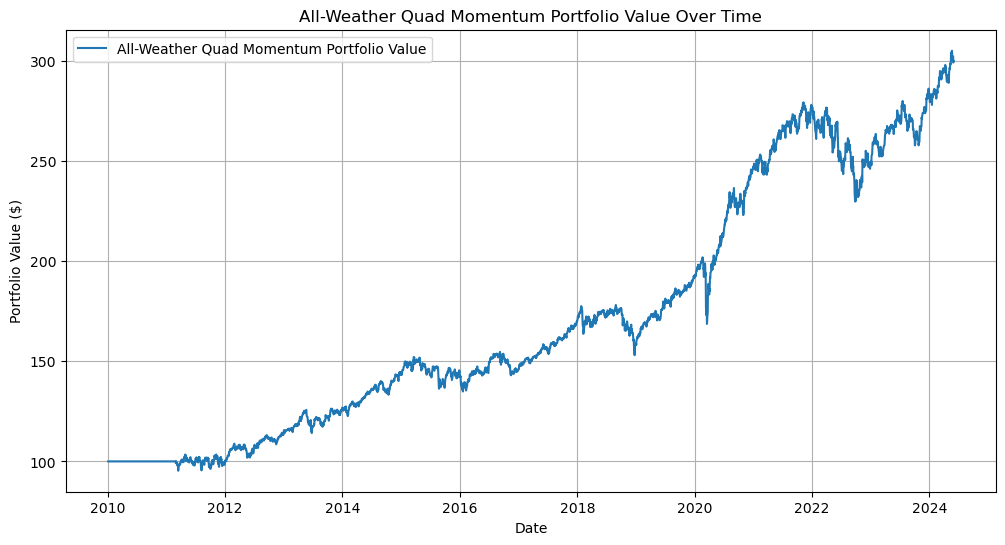

In [17]:
# Define the asset universe including defensive assets
tickers = {
    'domestic_equities': ['SPY', 'QQQ'],
    'international_equities': ['EFA', 'VEU'],
    'bonds': ['TLT', 'IEF'],
    'commodities_real_estate': ['VNQ', 'RWX', 'DBC', 'GLD'],
    'defensive_assets': ['BIL'],
    'cash': ['BIL']
}

# Download historical data
start_date = '2010-01-01'
data = yf.download(sum(tickers.values(), []), start=start_date)['Adj Close']

# Calculate monthly returns
monthly_data = data.resample('M').last()
monthly_returns = monthly_data.pct_change().dropna()

# Define lookback periods for long-term and short-term momentum
long_term_lookback = 12  # 10-12 months
short_term_lookback = 6  # 1-6 months

# Function to calculate momentum
def calculate_momentum(data, lookback_period):
    return data.pct_change(periods=lookback_period).dropna()

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=monthly_returns.index, columns=data.columns).fillna(0)

# Perform the strategy
for date in monthly_returns.index[max(long_term_lookback, short_term_lookback):]:
    for quadrant, assets in tickers.items():
        if quadrant == 'cash':
            continue
        # Calculate long-term and short-term momentum
        long_term_momentum = calculate_momentum(monthly_data.loc[:date, assets], long_term_lookback).iloc[-1]
        short_term_momentum = calculate_momentum(monthly_data.loc[:date, assets], short_term_lookback).iloc[-1]
        
        # Select top asset based on long-term momentum
        top_long_term_asset = long_term_momentum.idxmax()
        # Select top asset based on short-term momentum
        top_short_term_asset = short_term_momentum.idxmax()
        
        # Allocate 25% of the portfolio to each quadrant
        # Allocate 50% within each quadrant to top long-term asset and 50% to top short-term asset
        allocations.loc[date, top_long_term_asset] += 0.25 * 0.5
        allocations.loc[date, top_short_term_asset] += 0.25 * 0.5
    
    # Check if overall market sentiment is risk-off
    total_momentum = long_term_momentum.append(short_term_momentum)
    if total_momentum.mean() < 0:  # This is a simple risk-off trigger, can be improved
        for defensive_asset in tickers['defensive_assets']:
            allocations.loc[date, defensive_asset] = 0.25

# Forward fill the allocations to apply the same allocation until the next rebalance
daily_allocations = allocations.resample('D').ffill().reindex(data.index, method='ffill').fillna(0)

# Calculate daily returns
daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

# Calculate portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='All-Weather Quad Momentum Portfolio Value')
plt.title('All-Weather Quad Momentum Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
